# Assignment 3: Sensitivity Analysis with Sobol Indices
#### Moritz Kick, Maximilian Nowak

In [75]:
# Import modules from source
import os, sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin

# from sinfo import sinfo
# sinfo()

## Implementation of Sobol indices

### 1. Implement the construction of Sobol matrices

In [76]:
from assignment3.sobol import create_sobol_matrices

pass

### 2. Implement the computation of Sobol total-effect indices

In [77]:
from assignment3.sobol import compute_total_indices

pass

### 3. Verify your implementation

##### Test construction of Sobol matrices with different matrix sizes

In [78]:
from assignment2.lhs import latin_hypercube_uniform

for n_samples, dim in [(3,3), (4,4)]:
    A, B = latin_hypercube_uniform(dim, n_samples), latin_hypercube_uniform(dim, n_samples)  # Generate random samples
    A_B = create_sobol_matrices(A, B)  # Get sobol matrices

    print("Test %ix%i input matrices:" % (n_samples, dim))
    print("A:\n %s" % A)
    print("B:\n %s" % B)
    print("A_B:\n %s\n" % A_B)

Test 3x3 input matrices:
A:
 [[0.96577895 0.75866977 0.36304871]
 [0.11789351 0.65155408 0.20379258]
 [0.41140757 0.03396998 0.78906994]]
B:
 [[0.05829634 0.30294025 0.91100802]
 [0.68678303 0.65693245 0.36973558]
 [0.56675254 0.80813504 0.05276924]]
A_B:
 [[[0.05829634 0.75866977 0.36304871]
  [0.68678303 0.65155408 0.20379258]
  [0.56675254 0.03396998 0.78906994]]

 [[0.96577895 0.30294025 0.36304871]
  [0.11789351 0.65693245 0.20379258]
  [0.41140757 0.80813504 0.78906994]]

 [[0.96577895 0.75866977 0.91100802]
  [0.11789351 0.65155408 0.36973558]
  [0.41140757 0.03396998 0.05276924]]]

Test 4x4 input matrices:
A:
 [[0.63838944 0.24000599 0.14870001 0.21038667]
 [0.06305859 0.45377424 0.40890278 0.25485693]
 [0.40072609 0.90031725 0.74093639 0.5671315 ]
 [0.83752779 0.65361855 0.88752295 0.88341896]]
B:
 [[0.23678838 0.41406311 0.16556689 0.38078498]
 [0.36645036 0.65314539 0.38938356 0.98811644]
 [0.69709978 0.03480851 0.75016461 0.72095658]
 [0.82473977 0.84429153 0.69914166 0.072

##### Test computation of total-effect Sobol indices

In [79]:
from assignment2.lhs import latin_hypercube_uniform

# Generate matrices with Latin hypercube samples
n_samples = 100000
dim = 2
A, B = latin_hypercube_uniform(dim, n_samples), latin_hypercube_uniform(dim, n_samples)

# Get sobol matrices
A_B = create_sobol_matrices(A, B)

# Define test functions
f1 = lambda X: X[:, 0] + X[:, 1]  # f(x1, x2) = ax1 + bx2
f4 = lambda X: X[:, 0] + 10*X[:, 0]*X[:, 1] + X[:, 1]  # f(x1, x2) = ax1 + bx1x2 + cx2 

# f2 = lambda X: (1/np.sqrt(2))*X[:, 0] + X[:, 1]
# f3 = lambda X: X[:, 0] + X[:, 0]*X[:, 1]
# f4 = lambda X: 2*X[:, 0] + X[:, 0]*X[:, 1] +  2*X[:, 1]  # 

f5 = lambda X: 1 + np.log(X[:, 0]*X[:, 1])
# TODO: Display results 

for f in [f1, f4]:
    f_A = f(A)
    f_AB = np.array([f(X) for X in A_B])
    r = compute_total_indices(f_A, f_AB)
    print("%.6f %.6f" % (r[0], r[1]))
    print("sum: %.6f" % (np.sum(r)))

0.502912 0.501310
sum: 1.004222
0.557158 0.550687
sum: 1.107845


## Application to the model

### 4. Construct sample matrices $A, B ∈ R^{N×n}$

In [80]:
from assignment2.lhs import latin_hypercube_uniform

# Construct parameter domain like in assignment 2

beta_range = [1, 3]  # average number of contacts per week
alpha_range = [7/14, 7/2]  # mean latency rate per week
gamma_range = [7/14, 7/7]  # mean recovery rate per week
i0_range = [500, 2500]  # initial number of infected individuals

param_domain = np.array([beta_range, alpha_range, gamma_range, i0_range])

# LHS sampling
dim = 4
n_samples = 1000
A = latin_hypercube_uniform(dim=dim, n_samples=n_samples, low=param_domain[:, 0], high=param_domain[:, 1])
B = latin_hypercube_uniform(dim=dim, n_samples=n_samples, low=param_domain[:, 0], high=param_domain[:, 1])

print(A.shape)
print(B.shape)

(1000, 4)
(1000, 4)


### 5. Compute vectors $\mathcal{G}_l(A) ∈ R^N$ and $\mathcal{G}_l(A^{(i)}) ∈ R^N$

In [81]:
from assignment1.seir import seirc_model, G1, G2

# Define initial conditions and parameters

beta = 14/9  # infection rate
alpha = 7/3  # incubation rate
gamma = 7/9  # recovery rate
i0 = 1000  # initial number of infected individuals

N = 80e6
S0 = N - i0
E0 = 0
I0 = i0
R0 = 0
C0 = I0

# Simulation time
T = 60
t = np.linspace(0, T, T+1)

In [82]:
# prepare matrix A_b to sample parameter combinations
A_b = create_sobol_matrices(A, B)

# Apply g1 and g2 to A
A_g1 = []
A_g2 = []

for beta, alpha, gamma, i0 in A:
    S0 = N - i0
    y0 = [S0, E0, i0, R0, C0]  # update initial conditions with current sample of i0
    sol = seirc_model((beta, alpha, gamma, N)).solve(t, y0)
    A_g1.append(G1(sol[:, 4]))
    A_g2.append(G2(sol[:, 2], t))

A_g1 = np.array(A_g1)
A_g2 = np.array(A_g2)


# Apply g1 and g2 to each matrix in A_b
A_b_g1 = []
A_b_g2 = []
for A_bi in A_b:
    A_bi_g1 = []
    A_bi_g2 = []

    for beta, alpha, gamma, i0 in A_bi:
        S0 = N - i0
        y0 = [S0, E0, i0, R0, C0]  # update initial conditions with current sample of i0
        sol = seirc_model((beta, alpha, gamma, N)).solve(t, y0)
        A_bi_g1.append(G1(sol[:, 4]))
        A_bi_g2.append(G2(sol[:, 2], t))

    A_b_g1.append(np.array(A_bi_g1))
    A_b_g2.append(np.array(A_bi_g2))

A_b_g1 = np.array(A_b_g1)
A_b_g2 = np.array(A_b_g2)

### 6. Compute all Sobol total-effect indices $S_{Ti}$

In [83]:
sTi_g1 = compute_total_indices(A_g1, A_b_g1)
sTi_g2 = compute_total_indices(A_g2, A_b_g2)

print(sTi_g1.shape)
print(sTi_g2.shape)

(4,)
(4,)


### 7.  Display the indices with a bar plot

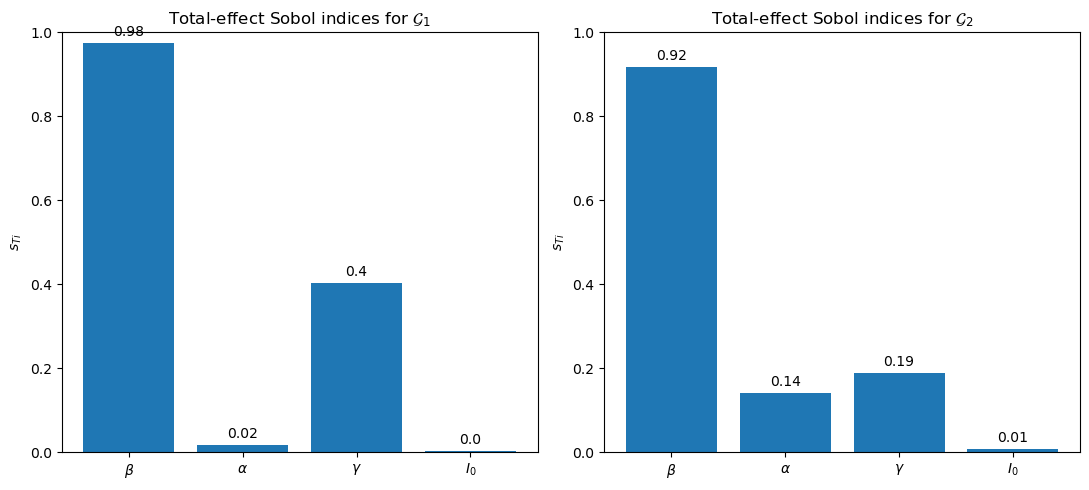

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
labels = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$I_0$']

# sTi1 for G1
bars1 = ax1.bar(labels, sTi_g1)
ax1.set_ylim(0, 1)
ax1.set_ylabel(r'$s_{Ti}$')
ax1.set_title(r'Total-effect Sobol indices for $\mathcal{G}_1$')

# Adding the exact sTi values on the bars for G1
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# sTi1 for G2
bars2 = ax2.bar(labels, sTi_g2)
ax2.set_ylim(0, 1)
ax2.set_ylabel(r'$s_{Ti}$')
ax2.set_title(r'Total-effect Sobol indices for $\mathcal{G}_2$')

# Adding the exact sTi1 values on the bars for G2
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 8. Find a way to quantify the "amount of interaction between the variables"

In [85]:
# sum of all sTi will be one if there's no interaction

# interaction in G1
sum_sTi_g1 = np.sum(sTi_g1)
inter_Xi_g1 = sum_sTi_g1 - 1
print("Interaction between variables Xi in G1: %.6f" % inter_Xi_g1)

# interaction in G2
sum_sTi_g2 = np.sum(sTi_g1)
inter_Xi_g2 = sum_sTi_g2 - 1
print("Interaction between variables Xi in G2: %.6f" % inter_Xi_g2)

Interaction between variables Xi in G1: 0.398113
Interaction between variables Xi in G2: 0.398113
